# Classification

## Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import anndata as ad
# import scanpy as sc
# import 

## Load embeddings and metadata

In [3]:
data = pd.read_csv('../data/raw/dataset_w_partition.csv', index_col=0)
data.index = data['Antibody  Name']
data.drop('Antibody  Name', axis=1, inplace=True)
display(data)

,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA,clus_vh,clus_vl,connected,partition
Antibody Name,,,,,,,,,,,,,,,,,,,
BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...,1442,682,0,Test
BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...,1443,508,1,Train
BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...,595,591,1,Train
BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...,1444,683,2,Test
BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...,1450,684,3,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...,2157,913,807,Test
BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...,2158,456,1,Train
BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...,2159,456,1,Train


In [4]:
with open('../data/processed/embed_EMS_8_seperate', 'rb') as f:
    esm_output = pickle.load(f)

In [5]:
hc_embedding = esm_output['representations'][6][:len(data), :].numpy()
lc_embedding = esm_output['representations'][6][len(data):, :].numpy()

In [6]:
X = np.concatenate([hc_embedding, lc_embedding], axis=1)

In [7]:
X_mean = X.mean(axis=1)

In [8]:
adata = ad.AnnData(X_mean)
adata.obs = data

In [9]:
X_train = adata.X[adata.obs['partition'] == 'Train']
X_test = adata.X[adata.obs['partition'] == 'Test']
y_train = adata.obs.loc[adata.obs['partition'] == 'Train', 'Epitope Group'].values
y_test = adata.obs.loc[adata.obs['partition'] == 'Test', 'Epitope Group'].values

## AutoML

In [23]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [34]:
from flaml import AutoML
settings = {
    "time_budget": 600,  # total running time in seconds
    # "max_iter": 2,
    "metric": 'micro_f1', 
    # "multiclass": "ovr",
    # "average": "weighted",
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'autoML_classification.log',  # flaml log file
    
    "seed": 7654321,    # random seed
}

automl = AutoML()
automl.fit(X_train, y_train, **settings)

[flaml.automl.logger: 01-17 15:17:35] {1680} INFO - task = classification
[flaml.automl.logger: 01-17 15:17:35] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 01-17 15:17:35] {1789} INFO - Minimizing error metric: 1-micro_f1
[flaml.automl.logger: 01-17 15:17:35] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-17 15:17:35] {2219} INFO - iteration 0, current learner lgbm


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: F

[flaml.automl.logger: 01-17 15:17:36] {2345} INFO - Estimated sufficient time budget=12558s. Estimated necessary time budget=289s.


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-17 15:17:36] {2392} INFO -  at 1.3s,	estimator lgbm's best error=0.6275,	best estimator lgbm's best error=0.6275
[flaml.automl.logger: 01-17 15:17:36] {2219} INFO - iteration 1, current learner lgbm


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: F

[flaml.automl.logger: 01-17 15:17:37] {2392} INFO -  at 2.2s,	estimator lgbm's best error=0.6275,	best estimator lgbm's best error=0.6275
[flaml.automl.logger: 01-17 15:17:37] {2219} INFO - iteration 2, current learner lgbm


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: F

[flaml.automl.logger: 01-17 15:17:41] {2392} INFO -  at 5.6s,	estimator lgbm's best error=0.5271,	best estimator lgbm's best error=0.5271
[flaml.automl.logger: 01-17 15:17:41] {2219} INFO - iteration 3, current learner xgboost


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-17 15:17:42] {2392} INFO -  at 7.4s,	estimator xgboost's best error=0.5984,	best estimator lgbm's best error=0.5271
[flaml.automl.logger: 01-17 15:17:42] {2219} INFO - iteration 4, current learner lgbm


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: F

[flaml.automl.logger: 01-17 15:17:56] {2392} INFO -  at 20.9s,	estimator lgbm's best error=0.5119,	best estimator lgbm's best error=0.5119
[flaml.automl.logger: 01-17 15:17:56] {2219} INFO - iteration 5, current learner xgboost


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-17 15:17:57] {2392} INFO -  at 22.4s,	estimator xgboost's best error=0.5984,	best estimator lgbm's best error=0.5119
[flaml.automl.logger: 01-17 15:17:57] {2219} INFO - iteration 6, current learner xgboost
[flaml.automl.logger: 01-17 15:18:02] {2392} INFO -  at 27.0s,	estimator xgboost's best error=0.5374,	best estimator lgbm's best error=0.5119
[flaml.automl.logger: 01-17 15:18:02] {2219} INFO - iteration 7, current learner extra_tree
[flaml.automl.logger: 01-17 15:18:02] {2392} INFO -  at 27.2s,	estimator extra_tree's best error=0.7580,	best estimator lgbm's best error=0.5119
[flaml.automl.logger: 01-17 15:18:02] {2219} INFO - iteration 8, current learner extra_tree
[flaml.automl.logger: 01-17 15:18:02] {2392} INFO -  at 27.4s,	estimator extra_tree's best error=0.7409,	best estimator lgbm's best error=0.5119
[flaml.automl.logger: 01-17 15:18:02] {2219} INFO - iteration 9, current learner rf
[flaml.automl.logger: 01-17 15:18:03] {2392} INFO -  at 27.9s,	estima

/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: F

[flaml.automl.logger: 01-17 15:19:02] {2392} INFO -  at 87.5s,	estimator lgbm's best error=0.4966,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:02] {2219} INFO - iteration 19, current learner extra_tree


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-17 15:19:03] {2392} INFO -  at 87.9s,	estimator extra_tree's best error=0.7216,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:03] {2219} INFO - iteration 20, current learner xgboost
[flaml.automl.logger: 01-17 15:19:27] {2392} INFO -  at 112.5s,	estimator xgboost's best error=0.4926,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:27] {2219} INFO - iteration 21, current learner xgboost
[flaml.automl.logger: 01-17 15:19:34] {2392} INFO -  at 119.3s,	estimator xgboost's best error=0.4926,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:34] {2219} INFO - iteration 22, current learner lgbm


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: F

[flaml.automl.logger: 01-17 15:19:48] {2392} INFO -  at 132.9s,	estimator lgbm's best error=0.4966,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:48] {2219} INFO - iteration 23, current learner rf


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-17 15:19:49] {2392} INFO -  at 133.6s,	estimator rf's best error=0.6988,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:49] {2219} INFO - iteration 24, current learner extra_tree
[flaml.automl.logger: 01-17 15:19:49] {2392} INFO -  at 134.2s,	estimator extra_tree's best error=0.7136,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:49] {2219} INFO - iteration 25, current learner extra_tree
[flaml.automl.logger: 01-17 15:19:50] {2392} INFO -  at 134.9s,	estimator extra_tree's best error=0.7136,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:50] {2219} INFO - iteration 26, current learner rf
[flaml.automl.logger: 01-17 15:19:51] {2392} INFO -  at 135.8s,	estimator rf's best error=0.6988,	best estimator xgboost's best error=0.4926
[flaml.automl.logger: 01-17 15:19:51] {2219} INFO - iteration 27, current learner xgboost
[flaml.automl.logger: 01-17 15:20:23] {2392} INFO -  at 167

/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: F

[flaml.automl.logger: 01-17 15:20:53] {2392} INFO -  at 197.9s,	estimator lgbm's best error=0.4957,	best estimator xgboost's best error=0.4783
[flaml.automl.logger: 01-17 15:20:53] {2219} INFO - iteration 31, current learner rf


/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[flaml.automl.logger: 01-17 15:20:52] {2392} INFO -  at 197.1s,	estimator rf's best error=0.6831,	best estimator xgboost's best error=0.4783
[flaml.automl.logger: 01-17 15:20:52] {2219} INFO - iteration 32, current learner rf
[flaml.automl.logger: 01-17 15:20:53] {2392} INFO -  at 197.6s,	estimator rf's best error=0.6831,	best estimator xgboost's best error=0.4783
[flaml.automl.logger: 01-17 15:20:53] {2219} INFO - iteration 33, current learner xgboost
[flaml.automl.logger: 01-17 15:21:14] {2392} INFO -  at 219.1s,	estimator xgboost's best error=0.4783,	best estimator xgboost's best error=0.4783
[flaml.automl.logger: 01-17 15:21:14] {2219} INFO - iteration 34, current learner rf
[flaml.automl.logger: 01-17 15:21:15] {2392} INFO -  at 220.2s,	estimator rf's best error=0.6831,	best estimator xgboost's best error=0.4783
[flaml.automl.logger: 01-17 15:21:15] {2219} INFO - iteration 35, current learner rf
[flaml.automl.logger: 01-17 15:21:15] {2392} INFO -  at 220.5s,	estimator rf's best er

In [30]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': np.float64(0.09999999999999995), 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': np.float64(0.0009765625), 'reg_lambda': np.float64(1.0)}
Best accuracy on validation data: 0.3725
Training duration of best run: 0.1758 s


In [31]:
automl.model.estimator

LGBMClassifier(learning_rate=np.float64(0.09999999999999995), max_bin=255,
               n_estimators=1, n_jobs=-1, num_leaves=4,
               reg_alpha=np.float64(0.0009765625), reg_lambda=np.float64(1.0),
               verbose=-1)

In [32]:
y_pred = automl.predict(X_test)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/joblojo/miniforge3/envs/aintibody/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


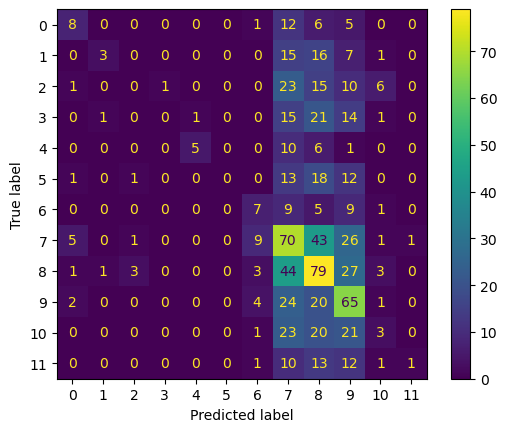

In [33]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [27]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))

Accuracy: 0.33902439024390246
Precision: 0.33902439024390246
